Підготуємо доступ до датасетів з kaggle. Попередьно завантажити файл kaggle.json


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Завантажуємо необхідні бібліотеки

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier



Завантажуємо обраний датасет

In [ ]:
! kaggle competitions download playground-series-s3e24
! mkdir /content/data
! unzip playground-series-s3e24.zip -d /content/data

  0% 0.00/6.81M [00:00<?, ?B/s]
100% 6.81M/6.81M [00:00<00:00, 70.0MB/s]
Archive:  playground-series-s3e24.zip
  inflating: /content/data/sample_submission.csv  
  inflating: /content/data/test.csv  
  inflating: /content/data/train.csv  


Завантажуємо дані в дата фрейм пандас



In [ ]:
train_dataset  = '/content/data/train.csv'
train = pd.read_csv(train_dataset)


Виводимо назви колонок, розмір датасету, видаляемо пропуски, видаляємо колонку id

In [ ]:
print("Назви колонок:")
print(train.columns)

print("\nРозмір датасета:")
print(train.shape)

train = train.dropna()
train = train.drop('id', axis=1)

print(train.nunique())

Назви колонок:
Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

Розмір датасета:
(159256, 24)
age                     18
height(cm)              14
weight(kg)              28
waist(cm)              531
eyesight(left)          20
eyesight(right)         17
hearing(left)            2
hearing(right)           2
systolic               112
relaxation              75
fasting blood sugar    229
Cholesterol            227
triglyceride           392
HDL                    108
LDL                    222
hemoglobin             134
Urine protein            6
serum creatinine        28
AST                    140
ALT                    188
Gtp                    362
dental ca

Будуємо Heatmap кореляцій

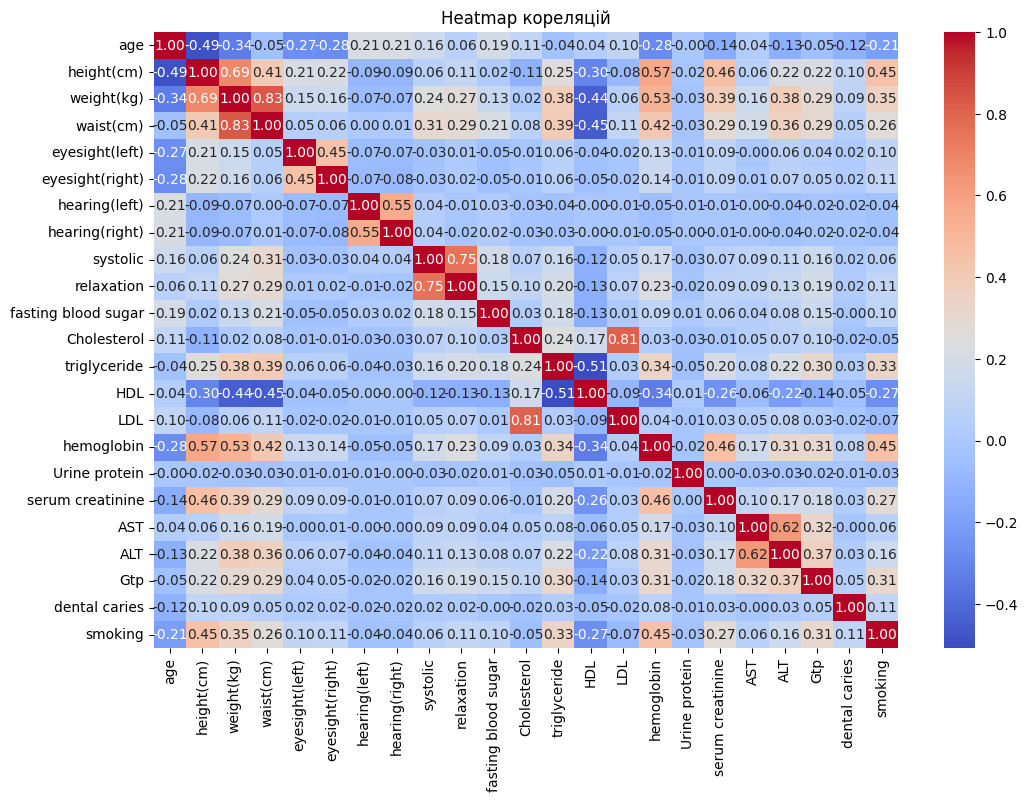

In [ ]:
plt.figure(figsize=(12, 8))
correlation_matrix = train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap кореляцій")
plt.show()

Гістограми розподілу ознак

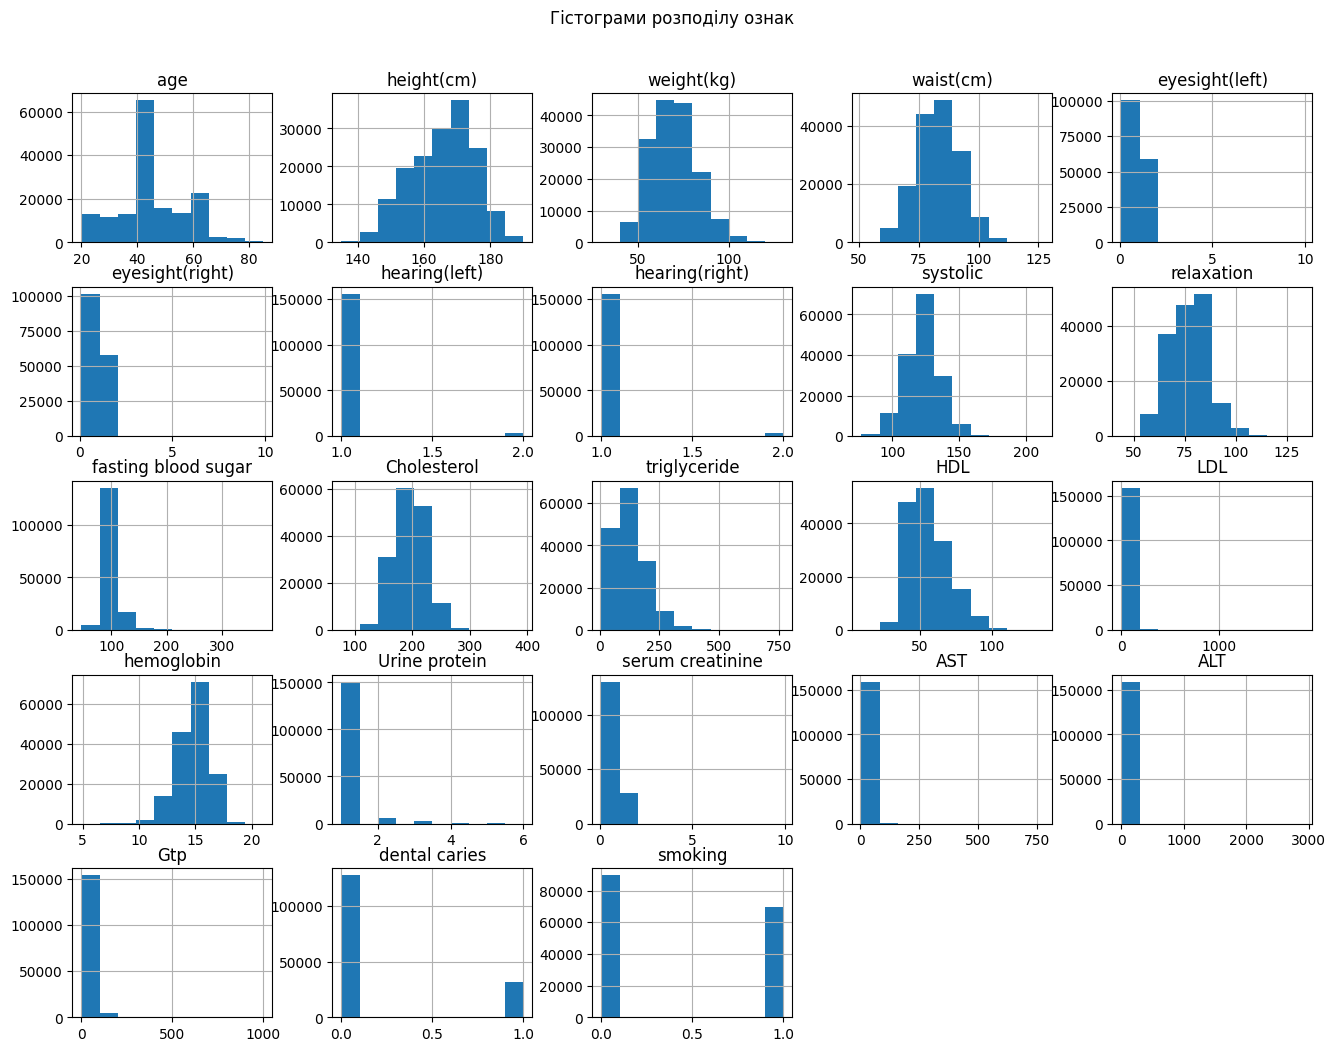

In [ ]:
train.hist(figsize=(16, 12))
plt.suptitle("Гістограми розподілу ознак", y=0.95)
plt.show()

Boxplot-и ознак відносно цільової змінної

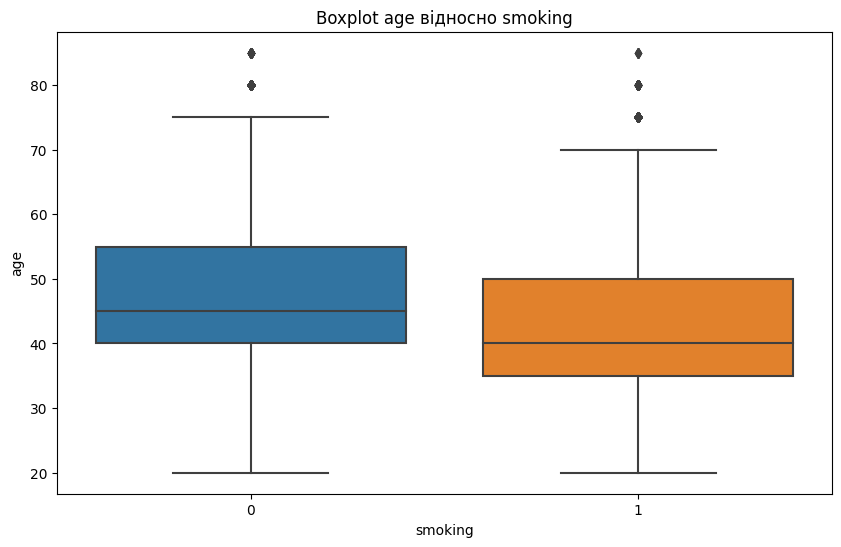

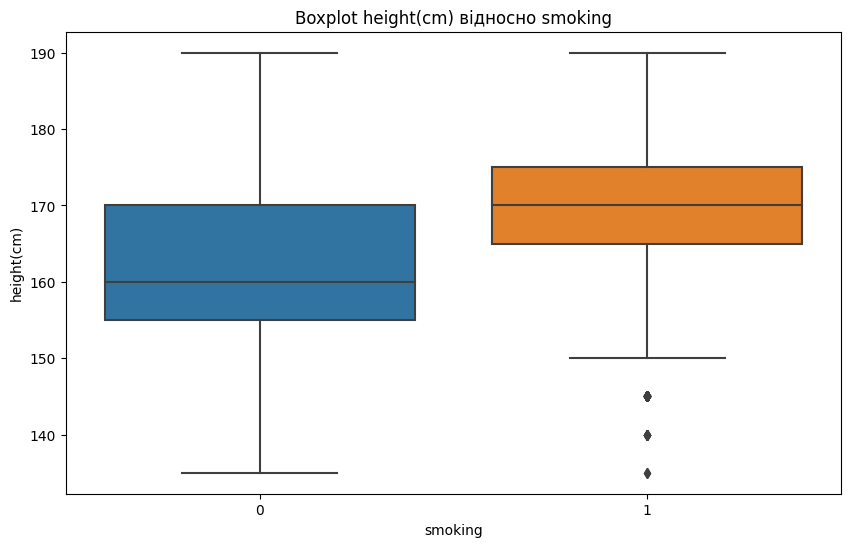

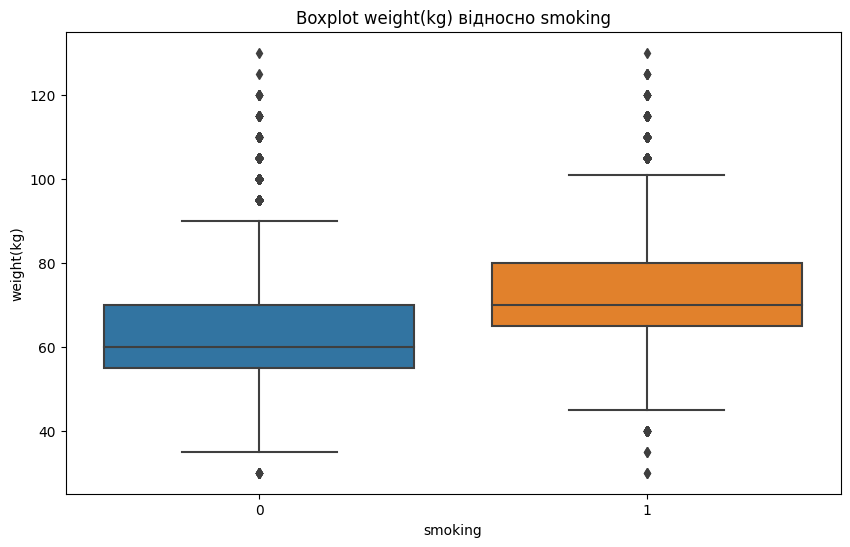

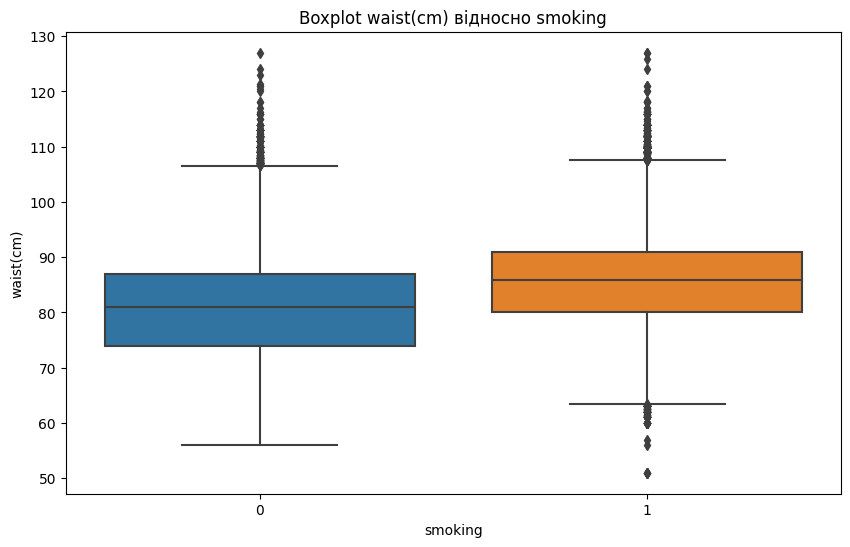

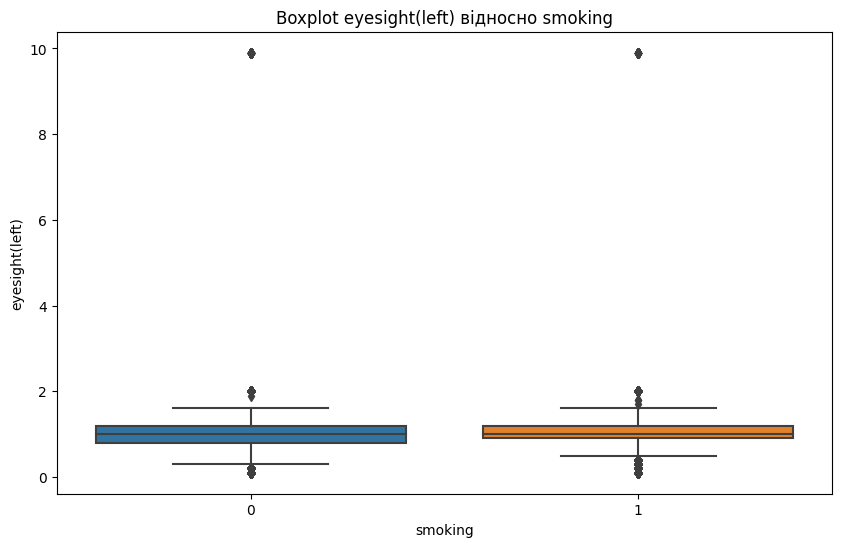

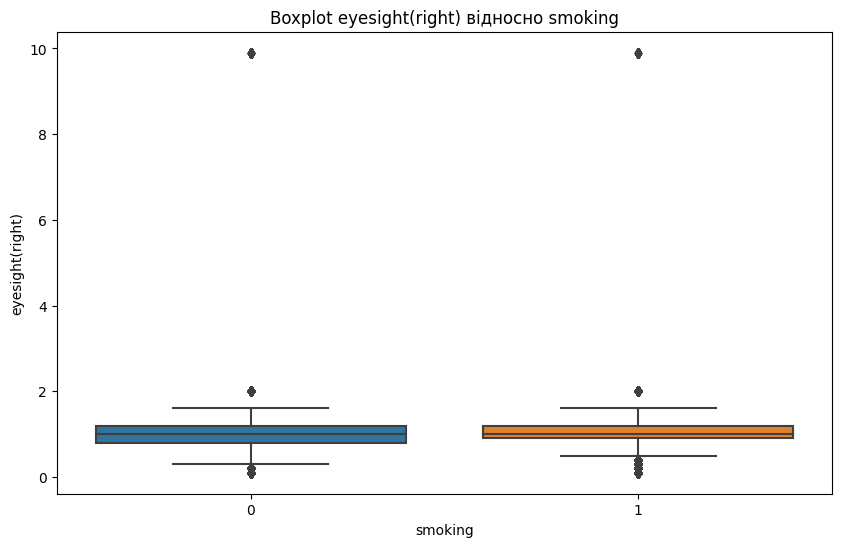

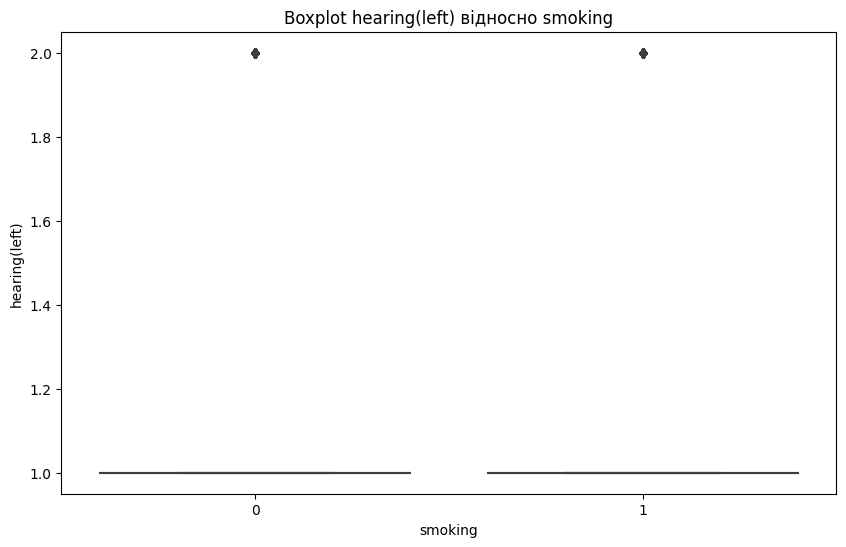

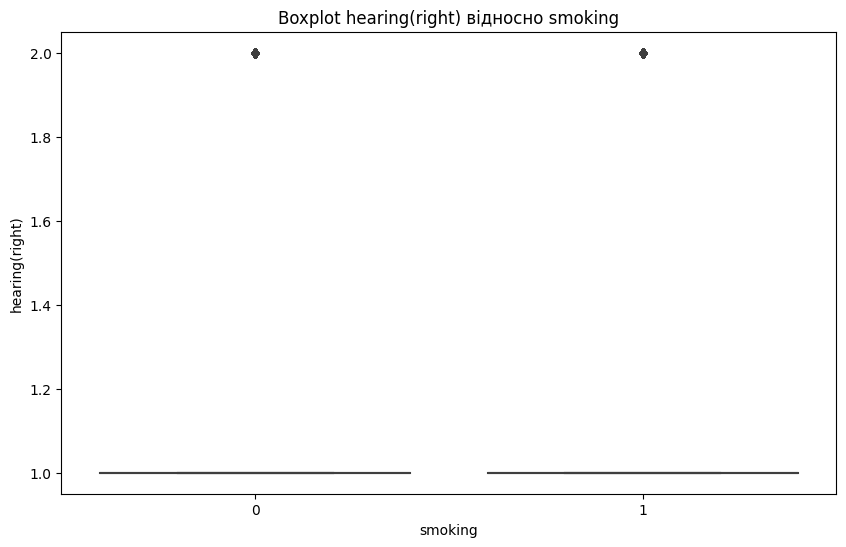

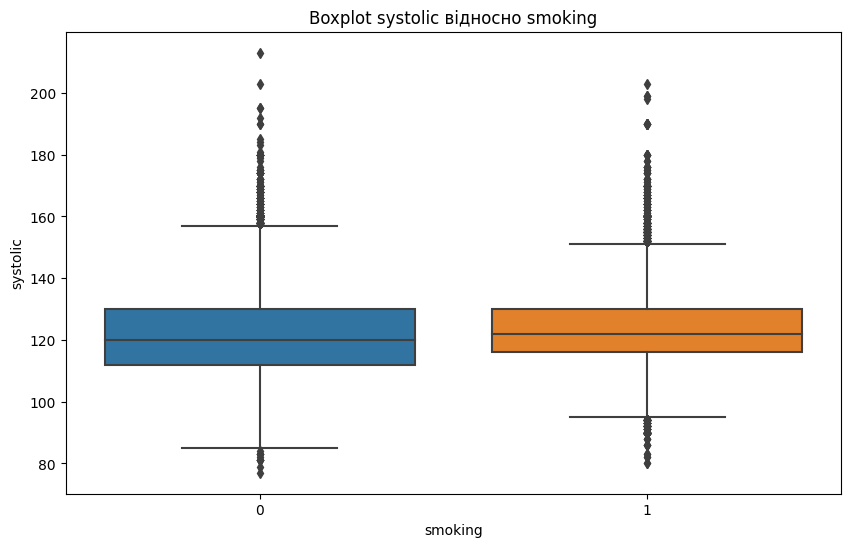

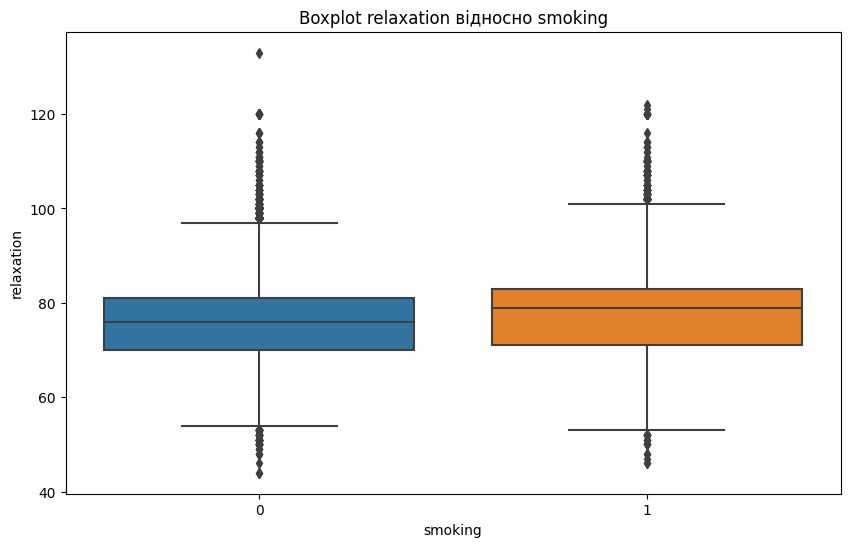

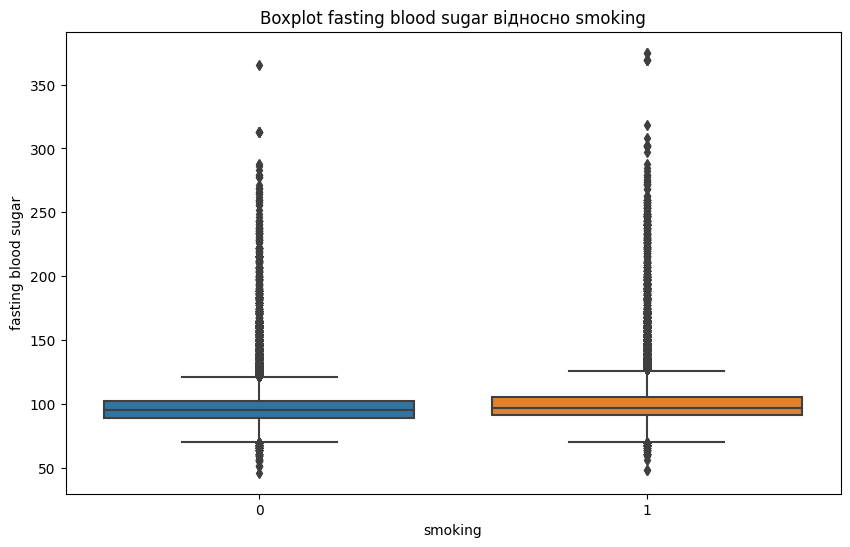

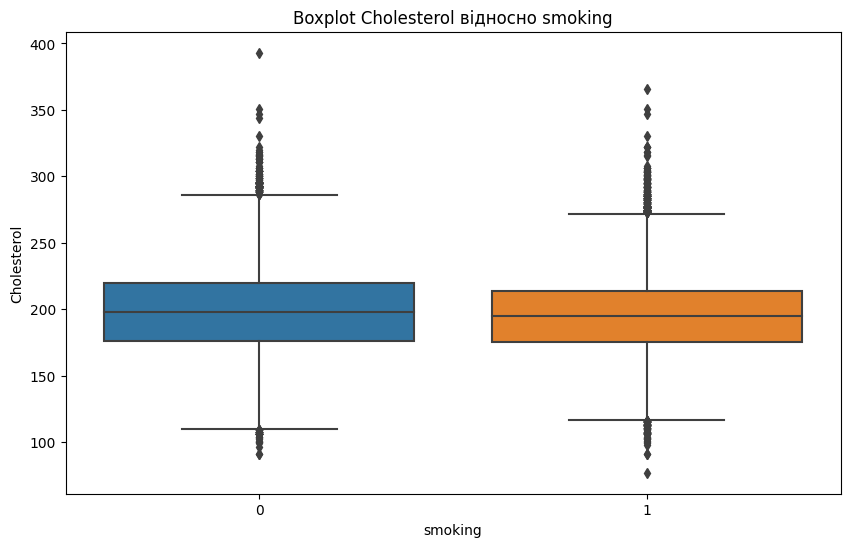

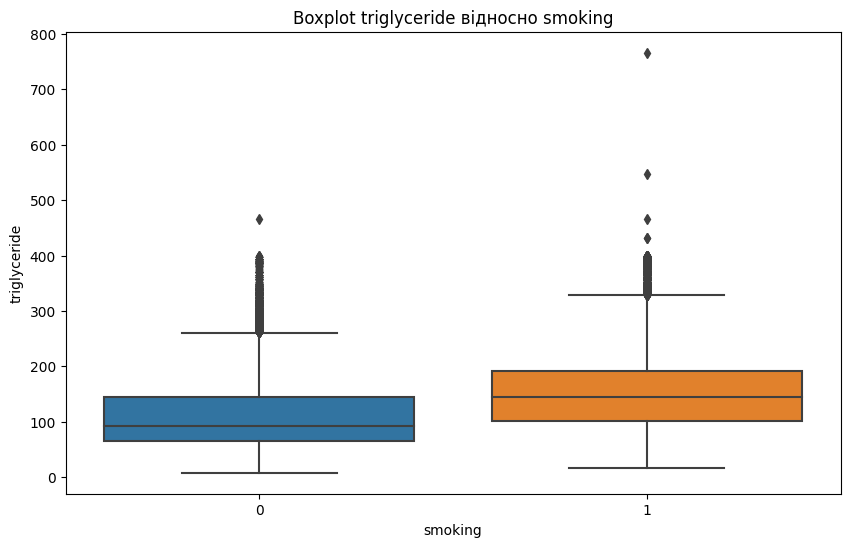

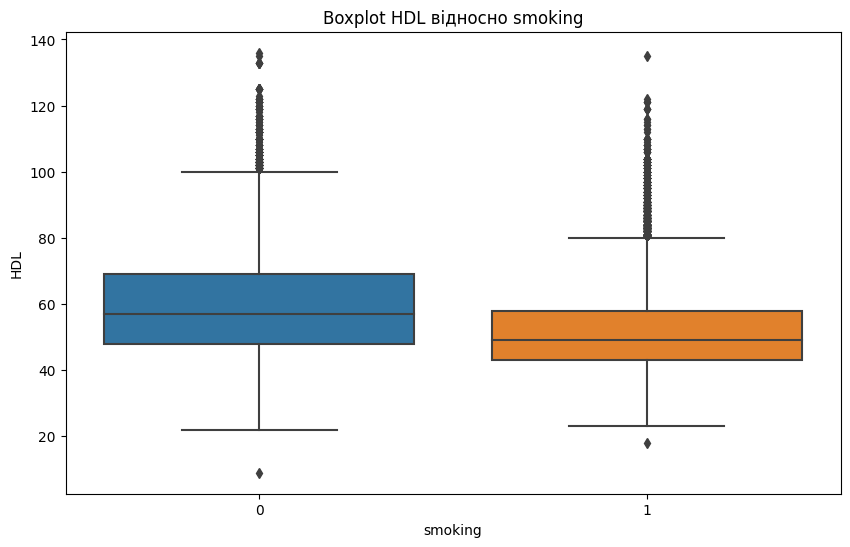

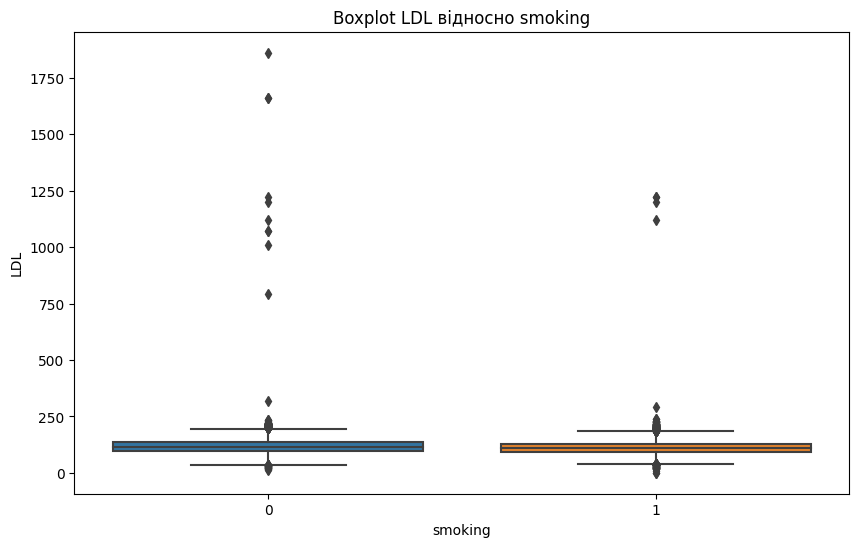

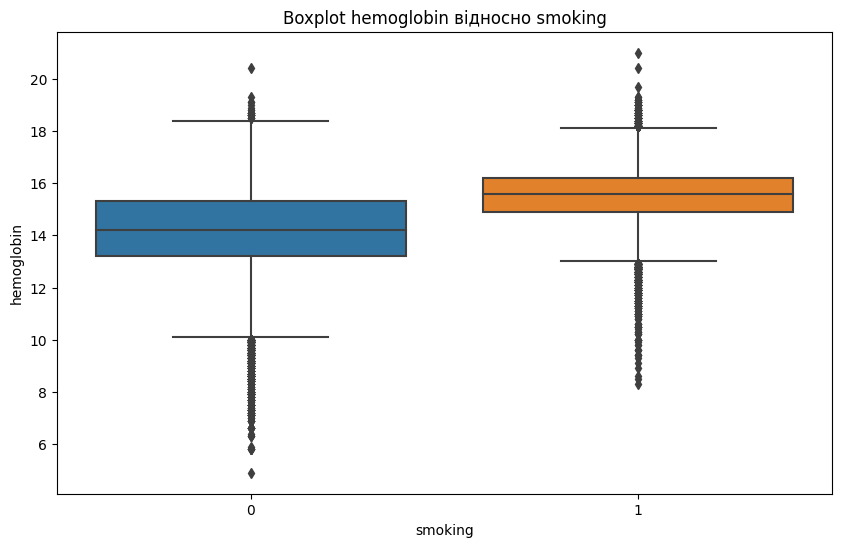

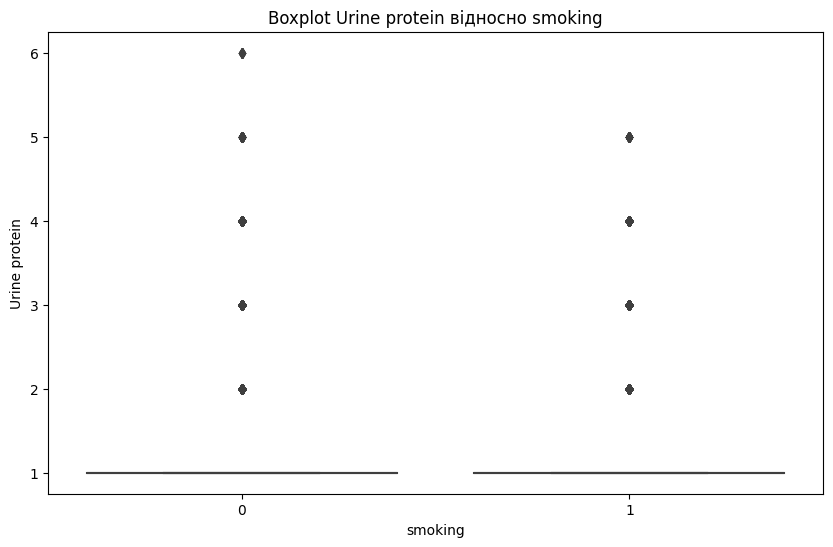

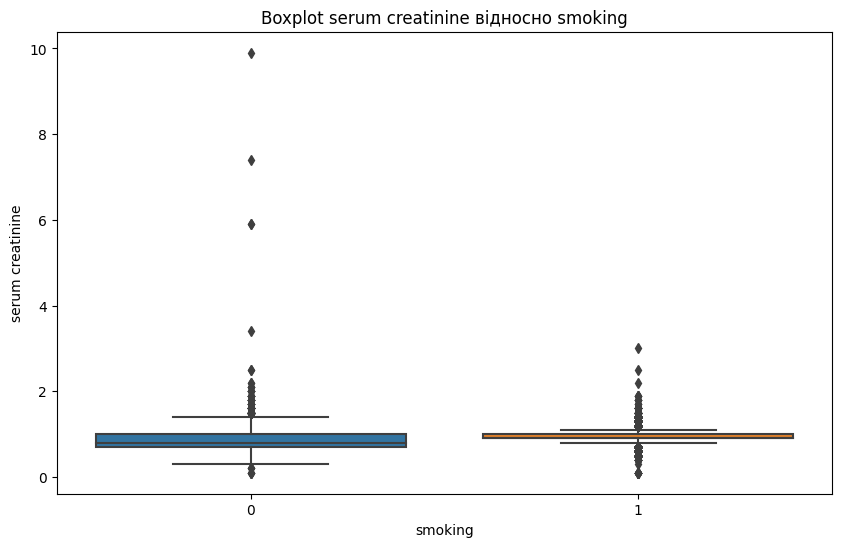

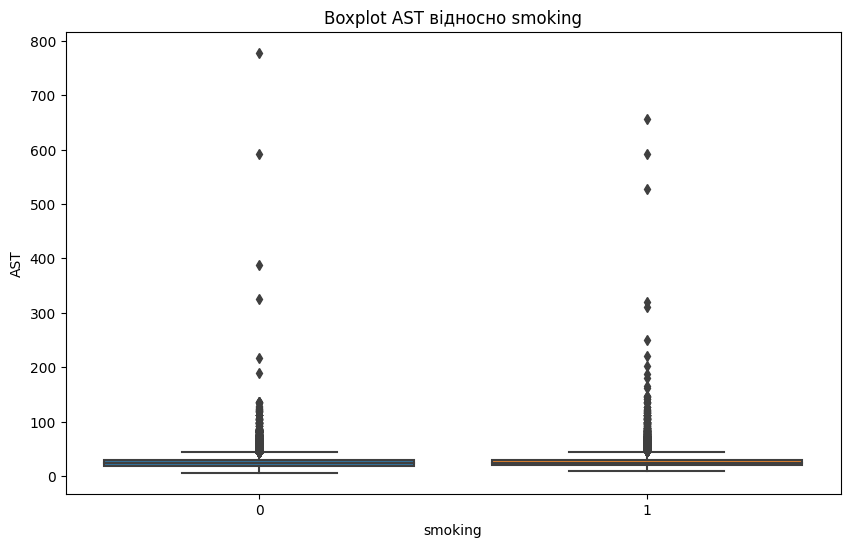

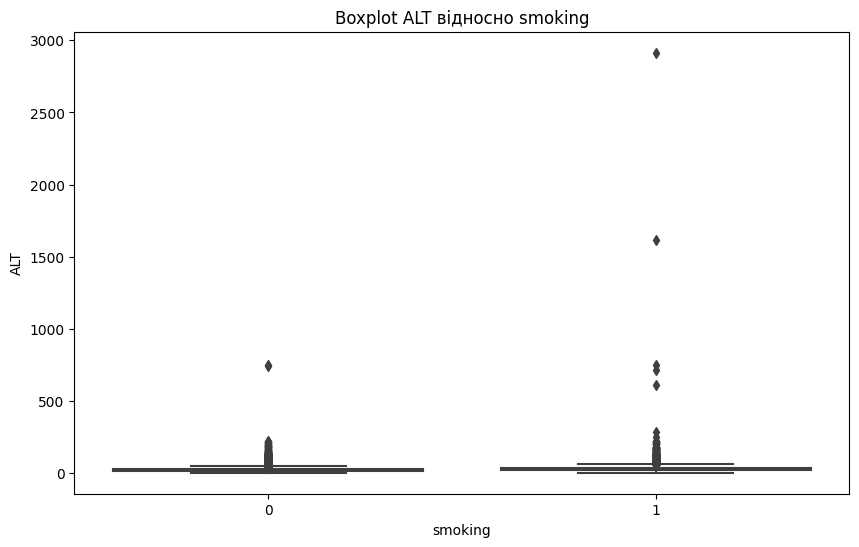

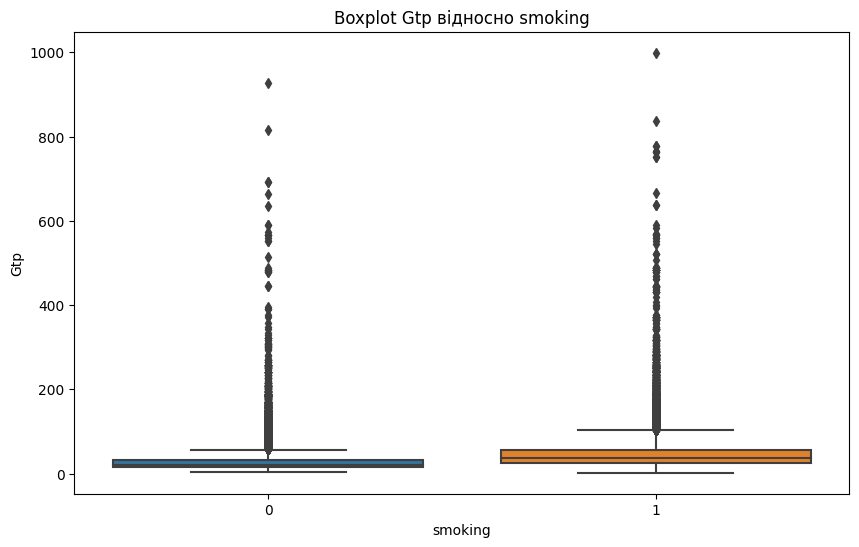

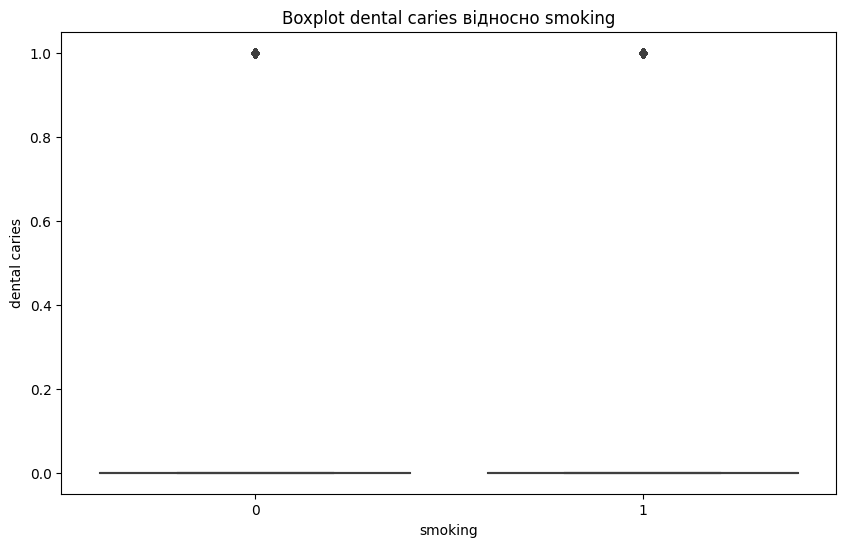

In [ ]:
target_column = "smoking"
for column in train.columns:
    if column != target_column:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=target_column, y=column, data=train)
        plt.title(f"Boxplot {column} відносно {target_column}")
        plt.show()

Нормалізація даних, без цільової змінної. Як можна побачити з попередніх пунктів - колонки dental caries, hearing(left) та hearing(right) - являють собою категоріальні дані. При цьому hearing(left) та hearing(right) - приймають значення 1 та 2. При нормалізації ці колонки не чіпаємо, але hearing(left) та hearing(right) замінимо 1:0, 2:1.

In [ ]:
columns_to_normalize = [ 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp']


scaler = MinMaxScaler()
train[columns_to_normalize] = scaler.fit_transform(train[columns_to_normalize])

target_column = 'hearing(left)'
train[target_column].replace({1: 0, 2: 1}, inplace=True)

target_column = 'hearing(right)'
train[target_column].replace({1: 0, 2: 1}, inplace=True)

print("Нормалізований DataFrame:")
print(train.head())

Нормалізований DataFrame:
        age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0  0.538462    0.545455        0.30   0.394737        0.040816   
1  0.769231    0.545455        0.35   0.500000        0.051020   
2  0.000000    0.636364        0.45   0.394737        0.030612   
3  0.230769    0.818182        0.65   0.710526        0.142857   
4  0.153846    0.545455        0.30   0.388158        0.142857   

   eyesight(right)  hearing(left)  hearing(right)  systolic  relaxation  ...  \
0         0.051020              0               0  0.426471    0.483146  ...   
1         0.061224              1               1  0.507353    0.438202  ...   
2         0.040816              0               0  0.301471    0.348315  ...   
3         0.112245              0               0  0.397059    0.494382  ...   
4         0.091837              0               0  0.323529    0.359551  ...   

        HDL       LDL  hemoglobin  Urine protein  serum creatinine       AST  \
0  0.244094  0.0

In [ ]:
y = train['smoking']
X = train.drop('smoking', axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:


knn_2 = KNeighborsClassifier(algorithm='auto')
parameters_KNN = {
    'n_neighbors': (30,60, 1),
    'leaf_size': (1,3,1),
    'p': (1,2),
                   }
grid_search_KNN = GridSearchCV(
    estimator=knn_2,
    param_grid=parameters_KNN,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)
best_model = grid_search_KNN.fit(X_train, y_train)
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

y_pred_2 = grid_search_KNN.predict(X_valid)
print(classification_report(y_valid, y_pred_2))
print(confusion_matrix(y_valid, y_pred_2))

Best leaf_size: 1
Best p: 1
Best n_neighbors: 60
              precision    recall  f1-score   support

           0       0.82      0.72      0.77     17783
           1       0.70      0.80      0.74     14069

    accuracy                           0.76     31852
   macro avg       0.76      0.76      0.76     31852
weighted avg       0.76      0.76      0.76     31852

[[12861  4922]
 [ 2836 11233]]


In [ ]:
clf_1 = tree.DecisionTreeClassifier()
clf_1 = clf_1.fit(X_train, y_train)
y_pred = clf_1.predict(X_valid)
print(classification_report(y_valid, y_pred))
print(confusion_matrix(y_valid, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.73      0.73     17783
           1       0.65      0.64      0.65     14069

    accuracy                           0.69     31852
   macro avg       0.69      0.69      0.69     31852
weighted avg       0.69      0.69      0.69     31852

[[12953  4830]
 [ 4995  9074]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

rfc = RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(X_train, y_train)
y_pred =rfc.predict(X_valid)
print(classification_report(y_valid, y_pred))
print(confusion_matrix(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.73      0.76     17783
           1       0.69      0.74      0.71     14069

    accuracy                           0.74     31852
   macro avg       0.73      0.74      0.73     31852
weighted avg       0.74      0.74      0.74     31852

[[13037  4746]
 [ 3676 10393]]


In [ ]:
aboost = AdaBoostClassifier(n_estimators=100, random_state=0)
aboost.fit(X_train,y_train)
y_pred = aboost.predict(X_valid)
print(classification_report(y_valid, y_pred))
print(confusion_matrix(y_valid, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.76      0.79     17783
           1       0.72      0.78      0.75     14069

    accuracy                           0.77     31852
   macro avg       0.77      0.77      0.77     31852
weighted avg       0.77      0.77      0.77     31852

[[13464  4319]
 [ 3053 11016]]


In [ ]:
param_grid = {'C': [  100, 1000],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf']}

grid = GridSearchCV(svm.SVC(), param_grid, verbose=3)

# fitting the model for grid search
grid.fit(X_train, y_train)
y_pred = grid.predict(X_valid)
print(classification_report(y_valid, y_pred))
print(confusion_matrix(y_valid, y_pred))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ........C=100, gamma=1, kernel=rbf;, score=0.771 total time=40.3min
[CV 2/5] END ........C=100, gamma=1, kernel=rbf;, score=0.770 total time=39.3min
[CV 3/5] END ........C=100, gamma=1, kernel=rbf;, score=0.771 total time=39.3min
[CV 4/5] END ........C=100, gamma=1, kernel=rbf;, score=0.772 total time=39.2min
[CV 5/5] END ........C=100, gamma=1, kernel=rbf;, score=0.773 total time=39.4min
[CV 1/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.767 total time=13.3min
[CV 2/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.766 total time=13.4min
[CV 3/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.765 total time=13.4min
[CV 4/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.769 total time=13.6min
[CV 5/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.771 total time=13.5min
[CV 1/5] END .....C=100, gamma=0.01, kernel=rbf;, score=0.760 total time=12.9min
[CV 2/5] END .....C=100, gamma=0.01, kernel=rbf;,

![Screenshot_14.png]()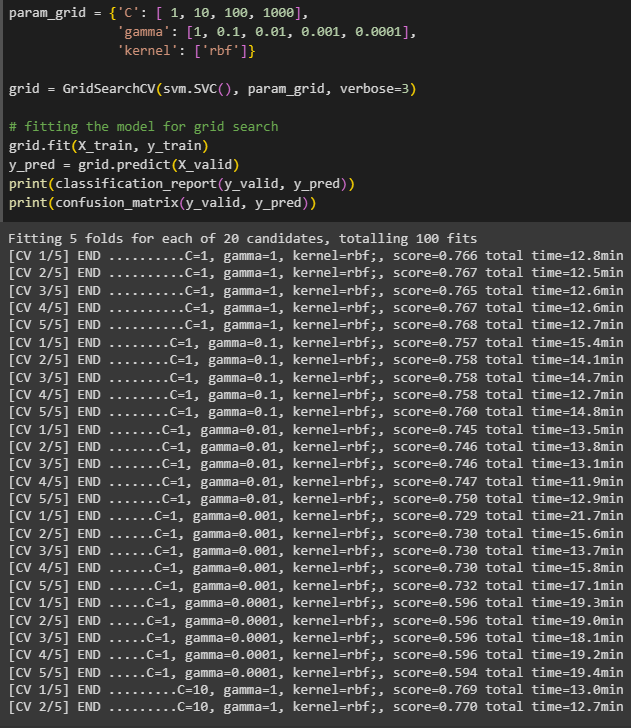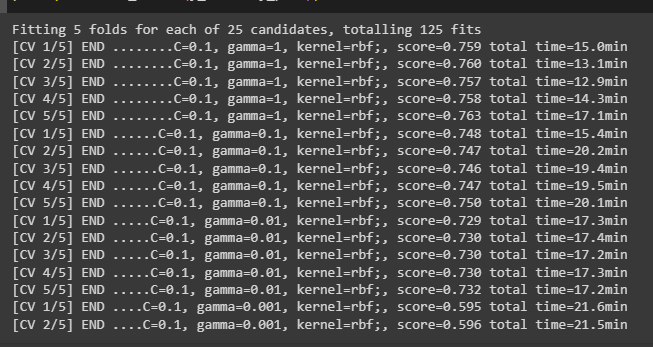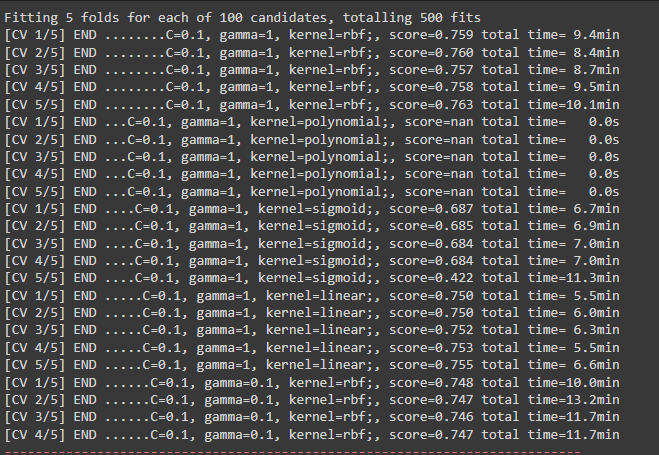

In [ ]:
svm_1 = svm.SVC()
svm_1.fit(X_train, y_train)
y_pred = svm_1.predict(X_valid)
print(classification_report(y_valid, y_pred))
print(confusion_matrix(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.71      0.77     17783
           1       0.69      0.83      0.76     14069

    accuracy                           0.76     31852
   macro avg       0.77      0.77      0.76     31852
weighted avg       0.78      0.76      0.76     31852

[[12647  5136]
 [ 2390 11679]]
